<a href="https://colab.research.google.com/github/DominikBurkert/RL_market_agent/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install entsoe-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00


In [3]:
from entsoe import EntsoePandasClient
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [4]:
#generate api key -> 
your_key = '0001b1f3-3601-42e9-b6a7-d359eee34c8d'
country_code = 'DE_LU'  # Germany-Luxembourg
client = EntsoePandasClient(api_key=your_key)

### Verschiedene Funktionen

1. get_demand()
  - get demand forecast in MWh
  - timesteps: 15 minutes
2. get_vre()
  - get Windoffshore, windonshore and solar generation in MWh
  - timesteps: 15 minutes
3. get_prices()
  - get Prices on the market in MWh
  - timesteps: 60 minutes

In [5]:
def get_demand(start, end):
    """
        Do some data manipulation from export from ENTSO-E, so get ready for the observation space
        Returns:
        Demand array for specified start and end date
    """
    df_load_prog = pd.DataFrame(client.query_load_forecast(country_code, start=start,end=end))
    df_load_prog.reset_index(inplace=True)
    df_load_prog.rename(columns={'index':'DateTime', 'Forecasted Load':'Forecasted Load [MWh]'}, inplace=True)

    
    df_load_prog.DateTime = pd.to_datetime(df_load_prog['DateTime'], utc=True)
    df_load_prog = df_load_prog.drop_duplicates(subset=['DateTime'])
    df_load_prog.set_index('DateTime', drop=True, append=False, inplace=True,
                     verify_integrity=True)
    
    df_load_prog.loc[df_load_prog['Forecasted Load [MWh]'] == '-'] = np.nan
    df_load_prog.dropna(axis=0, how='any',inplace=True)
    df_load_prog = df_load_prog['Forecasted Load [MWh]'].astype(np.float32)

    return df_load_prog


In [6]:
def get_vre(start, end):
    """
        Do some data manipulation from export from ENTSO-E, so get ready for the observation space
        Returns:
        Renewable Infeed array for specified start and end date
    """

    df_re_prog = pd.DataFrame(client.query_wind_and_solar_forecast(country_code, start=start,end=end, psr_type=None))
    df_re_prog.reset_index(inplace=True)
    df_re_prog.rename(columns={'index':'DateTime', 'Solar':'Forecasted Solar [MWh]', 'Wind Offshore':'Forecasted Wind Offshore [MWh]', 'Wind Onshore':'Forecasted Wind Onshore [MWh]'}, inplace=True)

   
    df_re_prog.DateTime = pd.to_datetime(df_re_prog['DateTime'], utc=True)
    df_re_prog = df_re_prog.drop_duplicates(subset=['DateTime'])
    df_re_prog.set_index('DateTime', drop=True, append=False, inplace=True,
                      verify_integrity=True)
    df_re_prog.loc[df_re_prog['Forecasted Solar [MWh]'] == '-'] = np.nan
    df_re_prog.loc[df_re_prog['Forecasted Wind Offshore [MWh]'] == '-'] = np.nan
    df_re_prog.loc[df_re_prog['Forecasted Wind Onshore [MWh]'] == '-'] = np.nan
    df_re_prog.dropna(axis=0, how='any',inplace=True)


    return df_re_prog

In [7]:
def get_prices(start, end):
    """
        Do some data manipulation from export from ENTSO-E, so get ready for the observation space
        
        Returns:
        Day-Ahead market price array for specified start and end date
    """

    # methods that return Pandas Series
    df_prices= pd.DataFrame(client.query_day_ahead_prices(country_code, start=start,end=end))
    df_prices.reset_index(inplace=True)
    df_prices.rename(columns={'index':'DateTime', 0:'Price [EUR/MWh]'}, inplace=True)
    
    df_prices.DateTime = pd.to_datetime(df_prices['DateTime'], utc=True)
    df_prices = df_prices.drop_duplicates(subset=['DateTime'])
    df_prices.set_index('DateTime', drop=True, append=False, inplace=True,
                  verify_integrity=True)
    df_prices.loc[df_prices['Price [EUR/MWh]'] == '-'] = np.nan
    df_prices = df_prices['Price [EUR/MWh]'].astype(np.float32)
    df_prices.dropna(axis=0, how='any',inplace=True)


    return df_prices


### Data Preprocessing
 - get data from entsoe
 - collect data in one dataframe
 - calculate residual load

In [8]:
start = pd.Timestamp('20190601', tz='Europe/Brussels')
end = pd.Timestamp('20200110', tz='Europe/Brussels')

#get data
df_demand =get_demand(start, end)
df_vre= get_vre(start, end) #get solar and wind onshore + offshore
df_prices=get_prices(start, end)


In [9]:
print(df_demand.shape)#every 15min
print(df_vre.shape)#every 15min
print(df_prices.shape)#hourly data

(21412,)
(21412, 3)
(5354,)


In [10]:
#concate all dataframes to one dataframe
data = pd.DataFrame(df_vre)
data['Demand in MWh'] = df_demand
data['total vre in MWh'] = df_vre['Forecasted Wind Offshore [MWh]'] + df_vre['Forecasted Wind Onshore [MWh]'] + df_vre['Forecasted Solar [MWh]']
#calculate residual load
data['residual load in MWh'] = data['Demand in MWh'] - data['total vre in MWh'] 
data['prices in €/MWh'] = df_prices
data = data.dropna()
print(data.shape)

(5353, 7)


In [11]:
#Problem: entso-e api returns DateTime with utc 0 -> for better understanding transform utc0 to utc2(Germany)
#example: right now: 31.05. 22Uhr (utc-0), transform to: 01.06 0:00Uhr (utc-2)    
data['local_DateTime'] = data.index + timedelta(hours=2)
data.set_index('local_DateTime', drop=True, append=False, inplace=True, verify_integrity=True)

<ipython-input-11-5c628ffde42b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['local_DateTime'] = data.index + timedelta(hours=2)


In [12]:
data.head(10)

,Forecasted Solar [MWh],Forecasted Wind Offshore [MWh],Forecasted Wind Onshore [MWh],Demand in MWh,total vre in MWh,residual load in MWh,prices in €/MWh
local_DateTime,,,,,,,
2019-06-01 00:00:00+00:00,0.0,2730.0,2056.0,42405.0,4786.0,37619.0,33.630001
2019-06-01 01:00:00+00:00,0.0,2887.0,2126.0,40510.0,5013.0,35497.0,31.030001
2019-06-01 02:00:00+00:00,0.0,3097.0,2549.0,38905.0,5646.0,33259.0,28.230000
2019-06-01 03:00:00+00:00,0.0,3353.0,3181.0,38329.0,6534.0,31795.0,27.620001
2019-06-01 04:00:00+00:00,0.0,3549.0,3907.0,38159.0,7456.0,30703.0,25.530001
2019-06-01 05:00:00+00:00,31.0,3855.0,4784.0,38635.0,8670.0,29965.0,23.139999
2019-06-01 06:00:00+00:00,922.0,3999.0,5210.0,39234.0,10131.0,29103.0,25.799999
2019-06-01 07:00:00+00:00,3984.0,4093.0,4979.0,42227.0,13056.0,29171.0,27.549999
2019-06-01 08:00:00+00:00,9251.0,3924.0,3901.0,46251.0,17076.0,29175.0,29.610001


### Save data as csv

In [18]:
data.to_csv("data.csv") #save data

In [14]:
#read data
"""
data= pd.read_csv('data.csv',delimiter=',')
data.set_index('local_DateTime', drop=True, append=False, inplace=True, verify_integrity=True)
data.head(5)
"""

"\ndata= pd.read_csv('data.csv',delimiter=',')\ndata.set_index('local_DateTime', drop=True, append=False, inplace=True, verify_integrity=True)\ndata.head(5)\n"

#### Visulasization of data

In [15]:
data.shape

(5353, 7)

<Axes: xlabel='local_DateTime'>

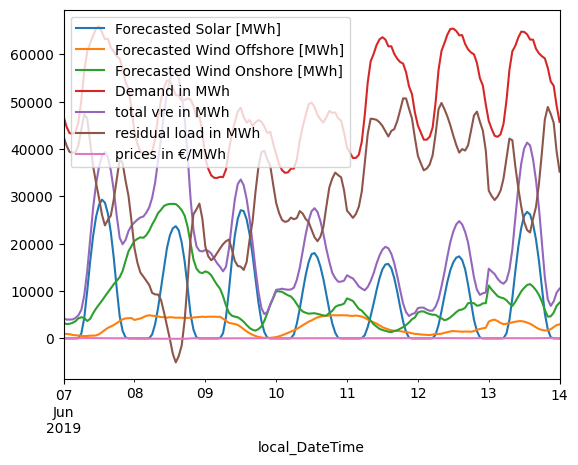

In [16]:
import matplotlib.pyplot as plt
#3 days in summer 
data['2019-06-07 00:00:00+00:00': '2019-06-14 00:00:00+00:00'].plot()

<Axes: xlabel='local_DateTime'>

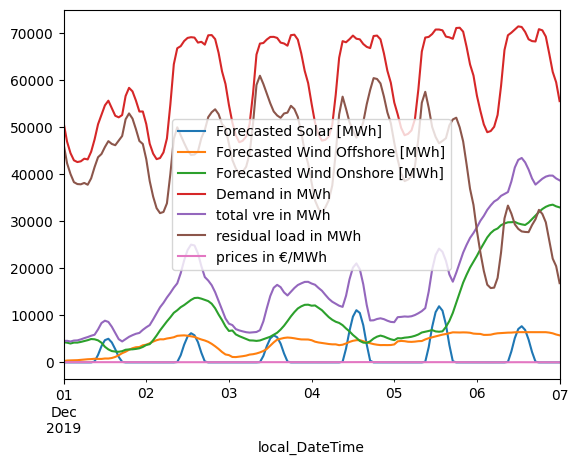

In [17]:
#winter week
data['2019-12-01 00:00:00+00:00': '2019-12-07 00:00:00+00:00'].plot()